I will test the accuracy of the numerical integration vs discrete Fourier transform methods of calculating the convolution integral. 
In order to have a known analytical solution to the convolution I will convolve 2 Gamma distributions, as it holds that: 

$Gamma(\alpha_1, \beta)*Gamma(\alpha_1, \beta)= Gamma(\alpha_1 + \alpha_2, \beta)$

Where to stay in line with the notation used in scipy the PDF of the Gamma distribution is described as: 

$f(x, \alpha, \beta) = \frac{\beta^{\alpha} x^{\alpha -1}e^{-\beta x}}{\Gamma(\alpha)}$

($\beta$ is given as the inverse of the scale parameter)

I first read in all the packages that are needed. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.interpolate import interp1d
from scipy.stats import gamma
import time

from treetime.node_interpolator import NodeInterpolator
from treetime.distribution import Distribution
from treetime.config import BIG_NUMBER, TINY_NUMBER, REL_TOL_PRUNE, BRANCH_GRID_SIZE, MAX_BRANCH_LENGTH

Then I create two Distribution objects for two Gamma distributions, I additionally define the analytical solution to their convolution. Note that the MAX_BRANCH_LENGTH parameter is set to 4 and anything that is longer will be cut off. Thus, it makes sense to use gamma distributions that are scaled smaller to prevent estimation issues. 

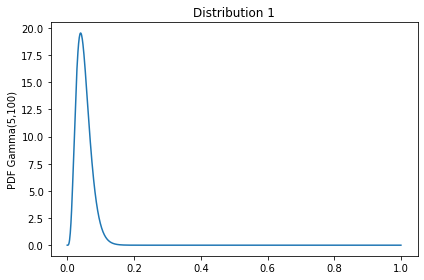

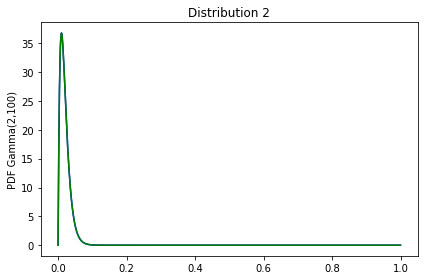

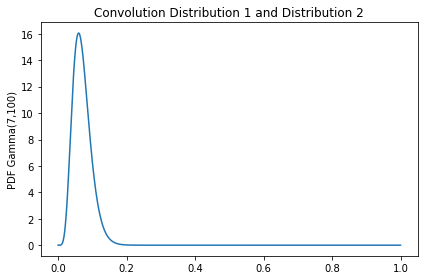

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [2]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

beta = 100
alpha_1 = 5
alpha_2 = 2

start = 0
end = 1
x = np.linspace(start, end, num=1000, endpoint=False) #create an x vector of points that should be sampled
y_1 = gamma.pdf(x, alpha_1, scale=1/beta)
y_1[y_1 == 0] = TINY_NUMBER ##remove -inf to prevent numerical errors

fig= plt.figure()
plt.autoscale()
plt.plot(x, gamma.pdf(x, alpha_1, scale=1/beta), label="PDF")
plt.ylabel("PDF Gamma("+ str(alpha_1) +","+str(beta)+ ")")
plt.title("Distribution 1")
plt.show()
dist_1 = Distribution(x, y_1, kind='linear', is_log=False)

y_2 = gamma.pdf(x, alpha_2, scale=1/beta)
y_2[y_2 == 0] = TINY_NUMBER ##remove -inf to prevent numerical errors

dist_2 = Distribution(x, y_2, kind='linear', is_log=False)

plt.figure()
plt.plot(x, gamma.pdf(x, alpha_2, scale=1/beta), color="blue")
plt.plot(x, np.exp(-dist_2.y), color="green") ##just to check that distribution object is initialized accurately 
plt.ylabel("PDF Gamma("+ str(alpha_2) +","+str(beta)+ ")")
plt.title("Distribution 2")
plt.show()


alpha_sol = alpha_1 + alpha_2
y_sol = gamma.pdf(x, alpha_sol, scale=1/beta)
y_sol[y_sol == 0] = TINY_NUMBER ##remove -inf to prevent numerical errors
dist_sol = Distribution(x, y_sol, kind='linear', is_log=False)
plt.figure()
plt.plot(x, gamma.pdf(x, alpha_sol, scale=1/beta))
plt.ylabel("PDF Gamma("+ str(alpha_sol) +","+str(beta)+ ")")
plt.title("Convolution Distribution 1 and Distribution 2")
plt.show()

plt.figure()

I shall now perform convolution on the two gamma distributions using the afore mentioned methods. I shall again vary the grid sizes used for convolution and see the effects on accuracy by comparing the output with the analytical solution.

In [3]:
def accuracy_and_time(dist_1, dist_2, calc_type, grid_size):
    '''
    Output: res - convolution output (Distribution object)
            conv_time - time needed for convolution
            true_grid_size - grid size of convolution output (as grid is set in convolution function and can vary)
    '''
    if calc_type=="fft":
        start = time.process_time()
        if alpha_1==1 or alpha_2==1:
            factor = 100
        else:
            factor = 50
        res = NodeInterpolator.convolve_fft(dist_1, dist_2, fft_grid_size=int(grid_size/factor))
        conv_time = time.process_time() - start
        true_grid_size = len(res.y)
    if calc_type=="num":
        start = time.process_time()
        res = NodeInterpolator.convolve(dist_1, dist_2, n_grid_points=grid_size, n_integral=grid_size)[0] ##second output is grid scale, which is also given in the x parameter
        conv_time = time.process_time() - start
        true_grid_size = len(res.y)
    return res, conv_time, true_grid_size

def get_P(x, neg_log_P):
    '''
    Given a Distribution object (neg_log_P) this returns the original likelihood function evaluated at points x
    As a Distribution object stores the function as the negative loglikelihood of the normalized function
    '''
    y = neg_log_P(x)
    y = np.exp(-y + neg_log_P.peak_val)
    return y

        

I am not sure what exactly the impact of the one_mutation parameter is.

In [4]:
##in order to perform the convolution dist_2 needs a one_mutation parameter (as this should be a BranchLenInterpolator object)
dist_2.one_mutation = 0

grid_size = [100, 200, 300, 500, 1000] #more desired grid_sizes, true grid size is given as output when the accuracy_and_time function is called
time_fft = np.empty((len(grid_size),2))
accuracy_fft = []
time_num = np.empty((len(grid_size),2))
accuracy_num = []
for t in range(len(grid_size)):
    #print(t)
    time_fft_full = accuracy_and_time(dist_1, dist_2, "fft", grid_size[t])
    time_fft[t] = time_fft_full[1:3]
    accuracy_fft.append(time_fft_full[0])
    time_num_full = accuracy_and_time(dist_1, dist_2, "num", grid_size[t])
    time_num[t] = time_num_full[1:3]
    accuracy_num.append(time_num_full[0])


First I just plot the probability density functions to get a visual assessment of the accuracy. I also do this in the log scale to get a better look at the tails, here it becomes clear that the probability density in the tails (after the effective support is slightly over estimated).

grid points NUM (output):139.0
grid points FFT (output):55.0


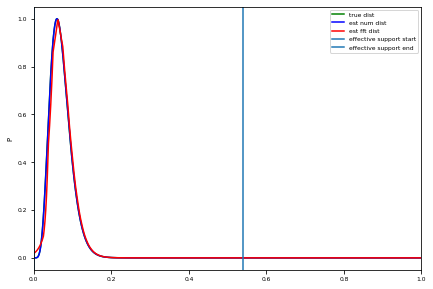

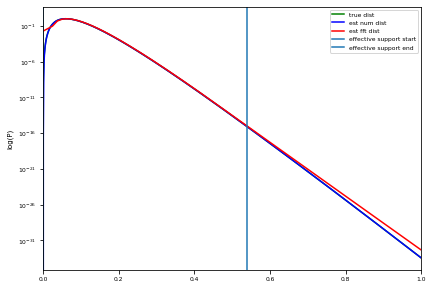

grid points NUM (output):178.0
grid points FFT (output):94.0


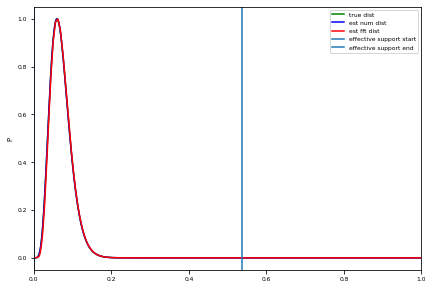

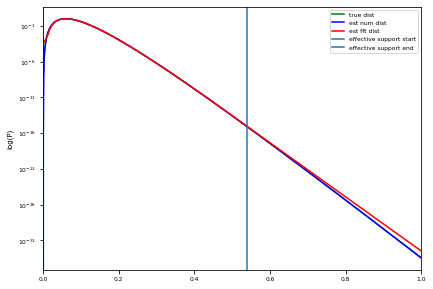

grid points NUM (output):237.0
grid points FFT (output):133.0


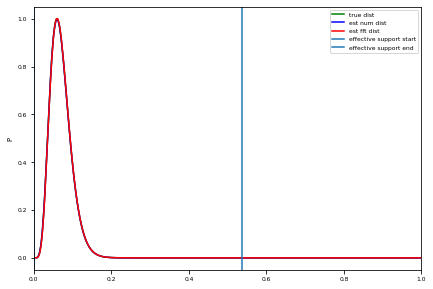

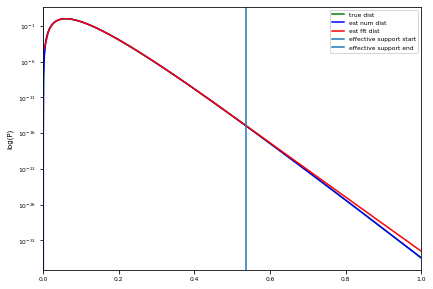

grid points NUM (output):336.0
grid points FFT (output):210.0


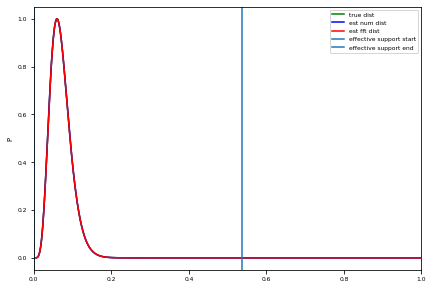

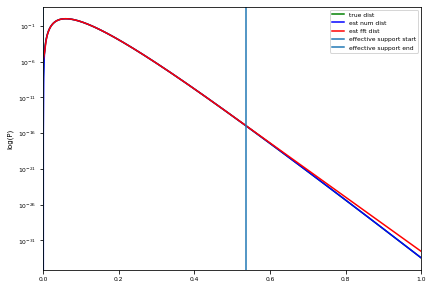

grid points NUM (output):585.0
grid points FFT (output):404.0


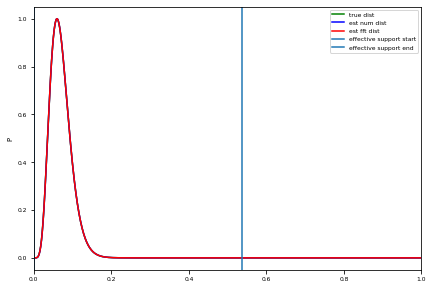

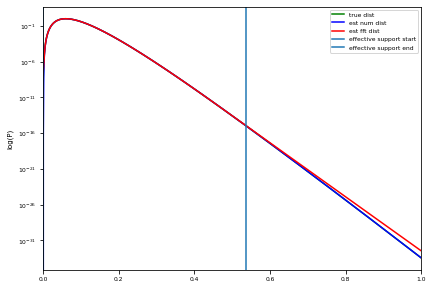

In [5]:
norm_y_sol = get_P(x, dist_sol)

def plot_P(accuracy_list_num, accuracy_list_fft, time_list_num, time_list_fft):
    for t in range(len(grid_size)):
        eff_support = accuracy_list_fft[t].effective_support
        print("grid points NUM (output):" +str(time_list_num[t][1]))
        norm_y_est_num = get_P(x, accuracy_list_num[t] )
        print("grid points FFT (output):" +str(time_list_fft[t][1]))
        norm_y_est_fft = get_P(x, accuracy_list_fft[t] )
        plt.figure()
        plt.rcParams['font.size'] = '6'
        #plt.autoscale()
        fig.tight_layout()
        #plt.subplot(1,2,1)
        plt.plot(x, norm_y_sol, color= "green", label="true dist")
        plt.plot(x, norm_y_est_num, color="blue", label="est num dist")
        plt.plot(x, norm_y_est_fft, color="red", label="est fft dist")
        plt.axvline(x=eff_support[0], label= "effective support start")
        plt.axvline(x=eff_support[1], label= "effective support end")
        plt.legend()
        plt.ylabel("P", fontsize=7)
        plt.xlim((0,1))
        plt.show()
        plt.close()
        plt.figure()
        #plt.subplot(1,2,2)
        plt.plot(x, norm_y_sol, color= "green", label="true dist")
        plt.plot(x, norm_y_est_num, color="blue", label="est num dist")
        plt.plot(x, norm_y_est_fft, color="red", label="est fft dist")
        plt.axvline(x=eff_support[0], label= "effective support start")
        plt.axvline(x=eff_support[1], label= "effective support end")
        plt.legend()
        plt.xlim((0,1))
        plt.yscale("log")
        plt.ylabel("log(P)", fontsize=7)
        plt.show()

plot_P(accuracy_num, accuracy_fft, time_num, time_fft)

I shall now plot the relative difference between the numerical solutions and the known analytical solution, normalizing by the analytical solution plus a constant epsilon. I always use the same vector of points x for comparison. But look at the numerical solution which has been derived using a varying number of grid points (the number of output grid points is iven as output before each plot). I additionally mark the start and end points of the effective support (calculated by the FFT-based convolution function) and zoom in on areas around these points.

FFT grid points (output):55.0
NUM grid points (output):139.0


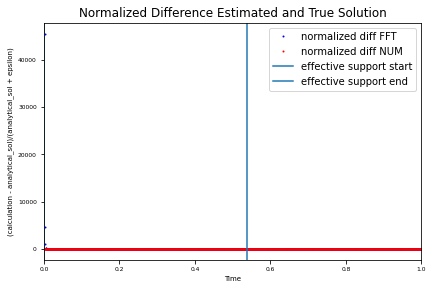

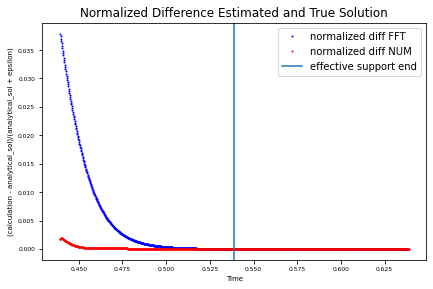

Absolute difference at end of effective support: 1.7446894109543054e-16
Absolute difference at end plus epsilon of effective support: 1.7446894096089317e-16
Absolute difference at start of effective support: 0.018129135323272576
FFT grid points (output):94.0
NUM grid points (output):178.0


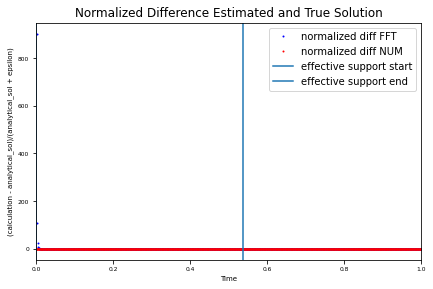

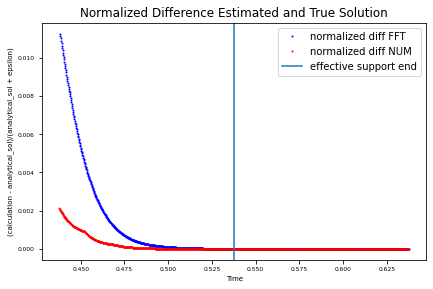

Absolute difference at end of effective support: 8.06501020057124e-17
Absolute difference at end plus epsilon of effective support: 8.065010194971787e-17
Absolute difference at start of effective support: 0.00025930022969111337
FFT grid points (output):133.0
NUM grid points (output):237.0


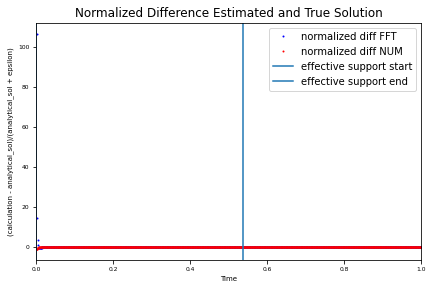

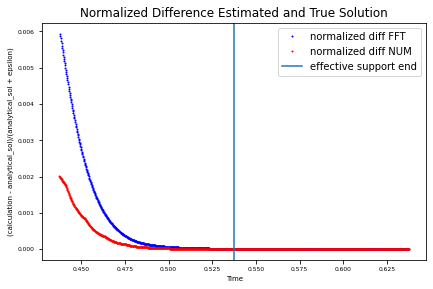

Absolute difference at end of effective support: 5.908943696526338e-17
Absolute difference at end plus epsilon of effective support: 5.908943692702335e-17
Absolute difference at start of effective support: 2.222308225667603e-05
FFT grid points (output):210.0
NUM grid points (output):336.0


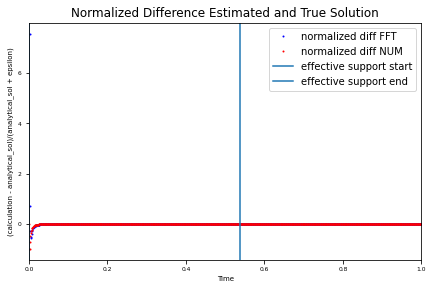

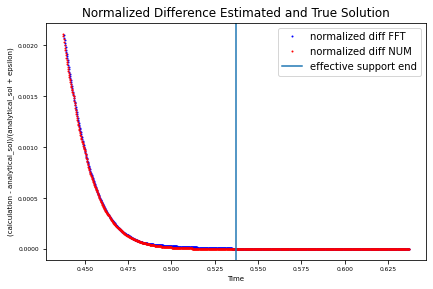

Absolute difference at end of effective support: 4.47803667162123e-17
Absolute difference at end plus epsilon of effective support: 4.478036668988841e-17
Absolute difference at start of effective support: 8.978842407242155e-07
FFT grid points (output):404.0
NUM grid points (output):585.0


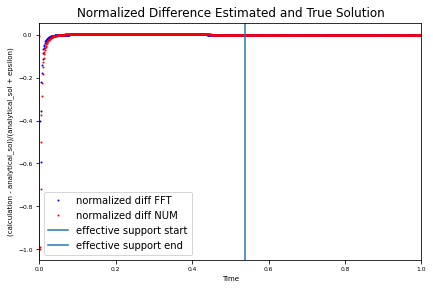

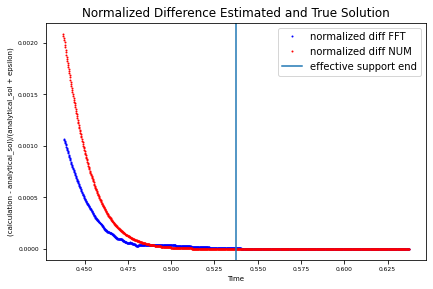

Absolute difference at end of effective support: 6.039131284771681e-17
Absolute difference at end plus epsilon of effective support: 6.039131281098508e-17
Absolute difference at start of effective support: 1.1241695420033124e-08


In [6]:
epsilon = 1e-11

def print_relative_diff(t):
    print("FFT grid points (output):" +str(time_fft[t][1]))
    print("NUM grid points (output):" +str(time_num[t][1]))
    eff_support = accuracy_fft[t].effective_support
    norm_y_est_fft = get_P(x, accuracy_fft[t])
    norm_y_est_num = get_P(x, accuracy_num[t])
    plt.figure()
    plt.plot(x[2:], ((norm_y_est_fft -norm_y_sol)/(norm_y_sol+epsilon))[2:], 'o', markersize=1, color="blue", label="normalized diff FFT")
    plt.plot(x, (norm_y_est_num -norm_y_sol)/(norm_y_sol+epsilon), 'o', markersize=1, color="red", label="normalized diff NUM")
    # plt.plot(x, norm_y_est_fft, 'o', markersize=1, color="blue", label="FFT")
    # plt.plot(x, norm_y_est_num, 'o', markersize=1, color="red", label="NUM")
    # plt.plot(x, norm_y_sol, 'o', markersize=1, color="green", label="analytical sol")
    plt.axvline(x=eff_support[0], label= "effective support start")
    plt.axvline(x=eff_support[1], label= "effective support end")
    plt.legend(prop={"size":10})
    plt.xlim((0,1))
    #plt.yscale("log")
    plt.ylabel("(calculation - analytical_sol)/(analytical_sol + epsilon)", fontsize=7)
    plt.xlabel("Time", fontsize=7)
    plt.title("Normalized Difference Estimated and True Solution", fontsize=12)

def print_relative_diff_grids(plot_support_closeup=True):
    for t in range(len(grid_size)):
        print_relative_diff(t)
        plt.show()
        eff_support = accuracy_fft[t].effective_support
        if plot_support_closeup:
            x_support = np.linspace(eff_support[1]-0.1, eff_support[1]+0.1, num=1000, endpoint=False) #create an x vector of points that should be sampled
            norm_y_sol_sup = get_P(x_support, dist_sol)
            norm_y_est_fft = get_P(x_support, accuracy_fft[t])
            norm_y_est_num = get_P(x_support, accuracy_num[t])  
            #print(accuracy_fft[t].x)
            plt.figure()
            plt.plot(x_support[2:], ((norm_y_est_fft -norm_y_sol_sup)/(norm_y_sol_sup+epsilon))[2:], 'o', markersize=1, color="blue", label="normalized diff FFT")
            #plt.plot(x_support, norm_y_est_num, 'o', markersize=1, color="red", label="normalized diff NUM")
            #plt.plot(x_support[2:], norm_y_est_fft[2:], 'o', markersize=1, color="blue", label="normalized diff FFT")
            #plt.plot(x_support, norm_y_sol_sup, 'o', markersize=1, color="green", label="normalized diff NUM")
            plt.plot(x_support, (norm_y_est_num -norm_y_sol_sup)/(norm_y_sol_sup+epsilon), 'o', markersize=1, color="red", label="normalized diff NUM")
            plt.ylabel("(calculation - analytical_sol)/(analytical_sol + epsilon)", fontsize=7)
            plt.xlabel("Time", fontsize=7)
            plt.title("Normalized Difference Estimated and True Solution", fontsize=12)
            plt.axvline(x=eff_support[1], label= "effective support end")
            plt.legend(prop={"size":10})
            #plt.yscale("log")
            plt.show()
            print("Absolute difference at end of effective support: " +str(get_P(eff_support[1] , accuracy_fft[t])- get_P(eff_support[1], dist_sol)))
            print("Absolute difference at end plus epsilon of effective support: " +str(get_P(eff_support[1] + epsilon, accuracy_fft[t])- get_P(eff_support[1]+epsilon, dist_sol)))
            print("Absolute difference at start of effective support: " +str(get_P(eff_support[0], accuracy_fft[t])- get_P(eff_support[0], dist_sol)))
        
print_relative_diff_grids(plot_support_closeup=True)


The start of the effective support is extremely overestimated for the FFT-based solution, this effect decreases as the grid size increases. However, what is more striking is the underestimation inside the effective support, I wonder if this is linked to the fac that the distributions are normalized and overestimating the left and right bounds would lead the center to be deflated. 

Further components to look at in more depth: 
 - The function performing numerical integration creates a grid where parts are linearly and parts are quadratically spaced, it would be interesting to see how this effects the accuracy and if this is responsible for the osscilation of the numerical approximation difference. 
 - Apply adjust_grid to the convolution function output and see if this has an effect on the accuracy.
 - Look into how BranchLenInterpolator and NodeInterpolator Distribution objects are stored (grid point location), apply this to the dist_1, dist_2 Distribution objects and check how this effects the accuracy. 


The convolve function creates an output grid which is linearly spaced around the center (estimated peak position) and then quadratically spaced to the left and right, with additional grid points added around 0. I shall add further vertical lines with the start and end position of this center linear grid. (I noticed that this linear center grid would span from -8 to 13 under regular circumstances but as the code will remove points lower than 0 these points are cut off)

This area will have additional grid points, if the interpolation error is above a pre-specified threshold, I did not check for this but this is most likely occuring as otherwise much less grid points would be used as there is no left quadratic grid. (Code seems to function similarly to adjust_grid function just instead of removing points we add points).

The bounds for the linear grid should be:-0.17200000000000004to 0.272
FFT grid points (output):55.0
NUM grid points (output):139.0


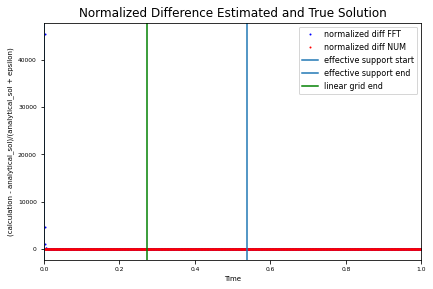

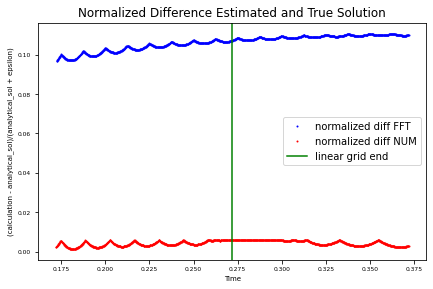

FFT grid points (output):94.0
NUM grid points (output):178.0


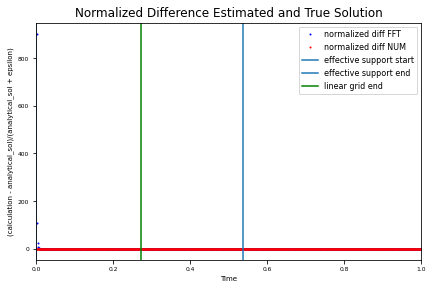

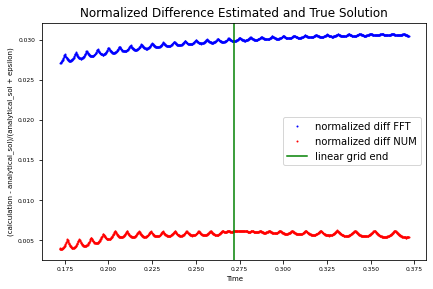

FFT grid points (output):133.0
NUM grid points (output):237.0


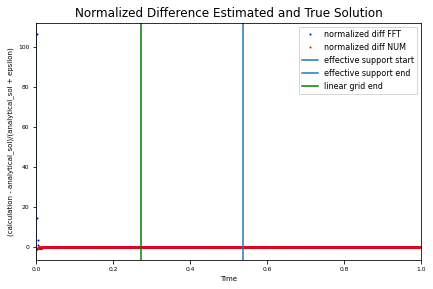

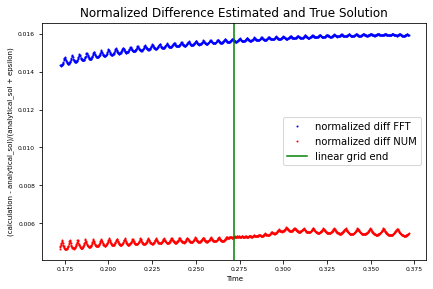

FFT grid points (output):210.0
NUM grid points (output):336.0


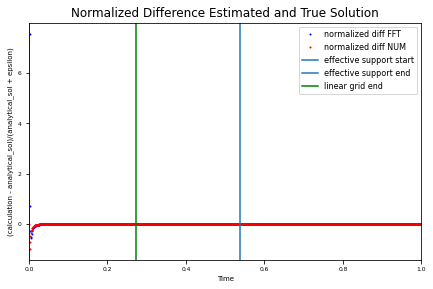

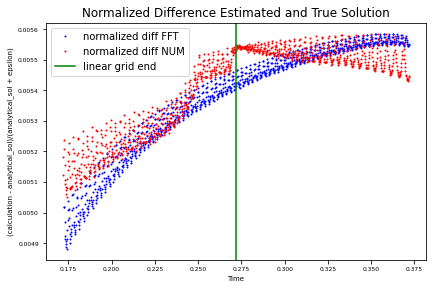

FFT grid points (output):404.0
NUM grid points (output):585.0


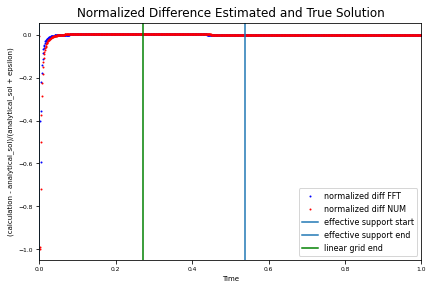

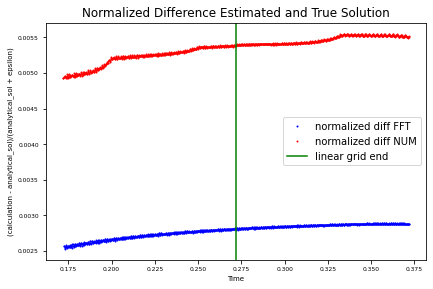

In [7]:
def get_convolve_linear_grid(dist_1, dist_2, pr=False):
    '''
    get the location of the start and end points of the linearly spaced output grid 
    of the convolve function applied to the Distribution objects dist_1 and dist_2
    '''
    est_new_peak_pos = dist_1.peak_pos + dist_2.peak_pos ##as we have assumed inverse time
    est_joint_fwhm  = (dist_1.fwhm + dist_2.fwhm)
    center_width = 3*est_joint_fwhm
    if pr:
        print("The bounds for the linear grid should be:" + str(est_new_peak_pos - center_width) + "to " + str(est_new_peak_pos + center_width))
    return max(est_new_peak_pos - center_width, 0), est_new_peak_pos + center_width

def print_relative_diff_grids_lin(print_lin_grid=True):
    start_conv_linear, end_conv_linear = get_convolve_linear_grid(dist_1, dist_2, True)
    for t in range(len(grid_size)):
        eff_support = accuracy_fft[t].effective_support
        print_relative_diff(t)
        plt.axvline(x=end_conv_linear, color="green", label= "linear grid end")
        plt.legend(prop={"size":8})
        plt.show()
        if print_lin_grid:

            x_linear = np.linspace(end_conv_linear-0.1, end_conv_linear+0.1, num=1000, endpoint=False) #create an x vector of points that should be sampled
            norm_y_sol_sup = get_P(x_linear, dist_sol)
            norm_y_est_fft = get_P(x_linear, accuracy_fft[t])
            norm_y_est_num = get_P(x_linear, accuracy_num[t])  
            plt.figure()
            plt.plot(x_linear[2:], ((norm_y_est_fft -norm_y_sol_sup)/(norm_y_sol_sup+epsilon))[2:], 'o', markersize=1, color="blue", label="normalized diff FFT")
            plt.plot(x_linear, (norm_y_est_num -norm_y_sol_sup)/(norm_y_sol_sup+epsilon), 'o', markersize=1, color="red", label="normalized diff NUM")
            plt.ylabel("(calculation - analytical_sol)/(analytical_sol + epsilon)", fontsize=7)
            plt.xlabel("Time", fontsize=7)
            plt.title("Normalized Difference Estimated and True Solution", fontsize=12)
            plt.axvline(x=end_conv_linear, color="green", label= "linear grid end")
            if (end_conv_linear+0.1 > eff_support[1]):
                plt.axvline(x=eff_support[1], color="blue", label= "effective support end")
            plt.legend(prop={"size":10})
            plt.show()

print_relative_diff_grids_lin(print_lin_grid=True)

FFT grid points (output):55.0
NUM grid points (output):139.0
FFT grid points, after adjusting grid (output):55
NUM grid points, after adjusting grid (output):139


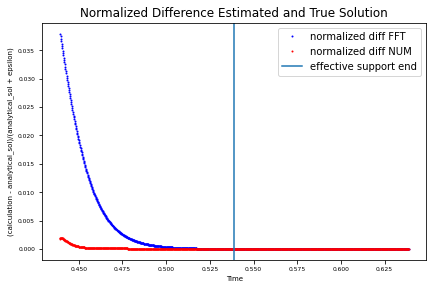

FFT grid points (output):94.0
NUM grid points (output):178.0
FFT grid points, after adjusting grid (output):94
NUM grid points, after adjusting grid (output):178


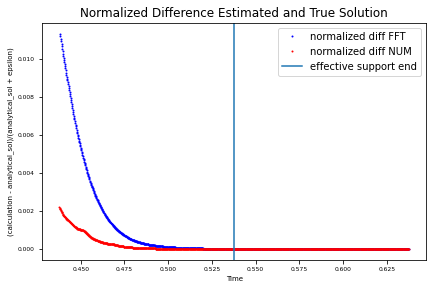

FFT grid points (output):133.0
NUM grid points (output):237.0
FFT grid points, after adjusting grid (output):133
NUM grid points, after adjusting grid (output):124


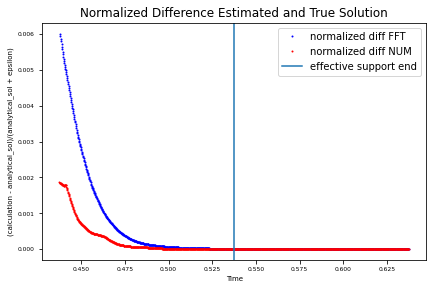

FFT grid points (output):210.0
NUM grid points (output):336.0
FFT grid points, after adjusting grid (output):108
NUM grid points, after adjusting grid (output):177


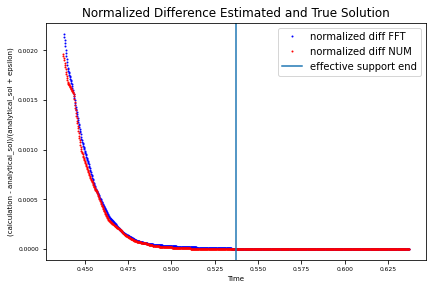

FFT grid points (output):404.0
NUM grid points (output):585.0
FFT grid points, after adjusting grid (output):105
NUM grid points, after adjusting grid (output):155


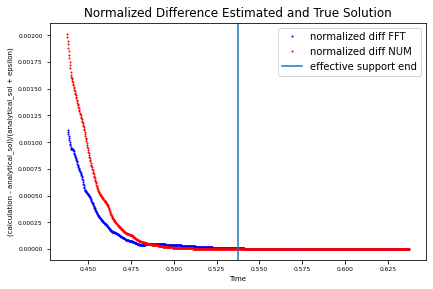

In [8]:
def plot_effects_adjust_grid():
    dist_sol._adjust_grid(rel_tol=REL_TOL_PRUNE)
    for t in range(len(grid_size)):
        eff_support = accuracy_fft[t].effective_support
        print("FFT grid points (output):" +str(time_fft[t][1]))
        print("NUM grid points (output):" +str(time_num[t][1]))
        accuracy_fft[t]._adjust_grid(rel_tol=REL_TOL_PRUNE)
        accuracy_num[t]._adjust_grid(rel_tol=REL_TOL_PRUNE)
        print("FFT grid points, after adjusting grid (output):" +str(len(accuracy_fft[t].y)))
        print("NUM grid points, after adjusting grid (output):" +str(len(accuracy_num[t].y)))
        x_support = np.linspace(eff_support[1]-0.1, eff_support[1]+0.1, num=1000, endpoint=False) #create an x vector of points that should be sampled
        norm_y_sol_sup = get_P(x_support, dist_sol)
        norm_y_est_fft = get_P(x_support, accuracy_fft[t])
        norm_y_est_num = get_P(x_support, accuracy_num[t])
        plt.figure()
        plt.plot(x_support[2:], ((norm_y_est_fft -norm_y_sol_sup)/(norm_y_sol_sup+epsilon))[2:], 'o', markersize=1, color="blue", label="normalized diff FFT")
        plt.plot(x_support, (norm_y_est_num -norm_y_sol_sup)/(norm_y_sol_sup+epsilon), 'o', markersize=1, color="red", label="normalized diff NUM")
        plt.ylabel("(calculation - analytical_sol)/(analytical_sol + epsilon)", fontsize=7)
        plt.xlabel("Time", fontsize=7)
        plt.title("Normalized Difference Estimated and True Solution", fontsize=12)
        plt.axvline(x=eff_support[1], label= "effective support end")
        plt.legend(prop={"size":10})

        plt.show()

plot_effects_adjust_grid()  

Noticibly the adjust_grid function has a large impact, typically removing half or more of the grid points when the grid is larger than 200. As this results in osscillations in the FFT error function as well this leads me to conclude that these are indeed caused by linear interpolation in locatiosn with less grid points.

Lastly I will store the dist_1 and dist_2 functions as they would be stored as BranchLenInterpolator or NodeInterpolator objects. The number of desired grid points is given in the config file under BRANCH_GRID_SIZE. These points are split evenly in the segments [0, mutation_length], [mutation length, 3* mutation_length], [3* mutation_length], [3*mutation_length, MAX_BRANCH_LENGTH]and the grid points are spaced quadratically, furthermore additional points are added around 0 to account for numerical errors. The MAX_BRANCH_LENGTH is set as 4 but I wil change this to 50 to be consistent with the functions I am using. NodeInterpolator objects' grids are not altered by initialization, however as they are either the product of time constraints or the result of convolution and adjust_grid operations I can assume they are also stored with a similar grid structure. 

As these gamma distributions are not linked ot a node I will use their (true) peak_pos as the mutation_length. 

4.0


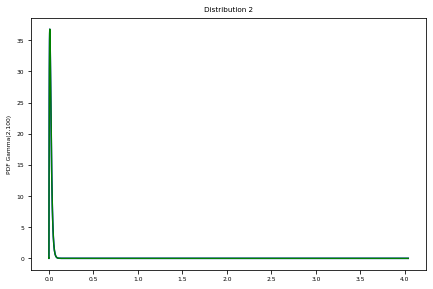

In [9]:
print(MAX_BRANCH_LENGTH) 
def get_BranchLenInterpolator_grid(sigma):
    n_grid_points = BRANCH_GRID_SIZE
    grid_left = sigma * (1 - np.linspace(1, 0.0, n_grid_points//3)**2.0)
    grid_zero = grid_left[1]*np.logspace(-20,0,6)[:5]
    grid_zero2 = grid_left[1]*np.linspace(0,1,10)[1:-1]
    # from optimal branch length to the right (--> 3*branch lengths),
    grid_right = sigma + (3*sigma*(np.linspace(0, 1, n_grid_points//3)**2))
    # far to the right (3*branch length ---> MAX_LEN), very sparse
    far_grid = grid_right.max() + MAX_BRANCH_LENGTH*np.linspace(0, 1, n_grid_points//3)**2

    grid = np.concatenate((grid_zero,grid_zero2, grid_left,grid_right[1:],far_grid[1:]))
    grid.sort() # just for safety
    return grid

sigma_1 = dist_1.peak_pos
sigma_2 = dist_2.peak_pos
x_1 = get_BranchLenInterpolator_grid(sigma_1)
x_2 = get_BranchLenInterpolator_grid(sigma_2)
y_1_bl = gamma.pdf(x_1, alpha_1, scale=1/beta)
y_1_bl[y_1_bl == 0] = TINY_NUMBER ##remove -inf to prevent numerical errors

dist_1_bl = Distribution(x_1, y_1_bl, kind='linear', is_log=False)

y_2_bl = gamma.pdf(x_2, alpha_2, scale=1/beta)
y_2_bl[y_2_bl == 0] = TINY_NUMBER ##remove -inf to prevent numerical errors

dist_2_bl = Distribution(x_2, y_2_bl, kind='linear', is_log=False)

plt.figure()
plt.plot(x_2, gamma.pdf(x_2, alpha_2, scale=1/beta), color="blue")
plt.plot(x_2, np.exp(-dist_2_bl.y), color="green") ##just to check that distribution object is initialized accurately 
plt.ylabel("PDF Gamma("+ str(alpha_2) +","+str(beta)+ ")")
plt.title("Distribution 2")
plt.show()

alpha_sol = alpha_1 + alpha_2
y_sol = gamma.pdf(x, alpha_sol, scale=1/beta)
y_sol[y_sol == 0] = TINY_NUMBER ##remove -inf to prevent numerical errors
dist_sol = Distribution(x, y_sol, kind='linear', is_log=False)


FFT grid points (output):57.0
NUM grid points (output):147.0


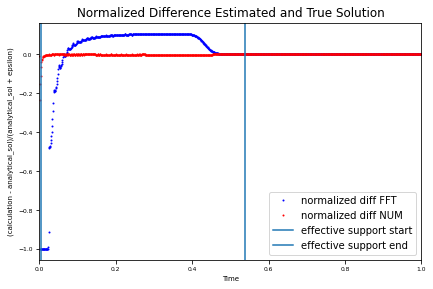

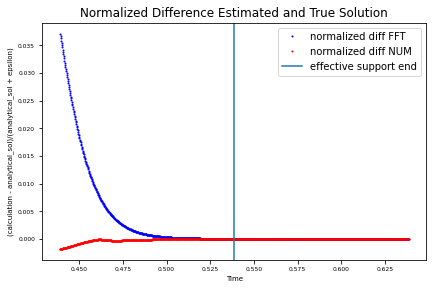

Absolute difference at end of effective support: 1.531541166858118e-16
Absolute difference at end plus epsilon of effective support: 1.5315411656725164e-16
Absolute difference at start of effective support: -0.00010220614223783279
FFT grid points (output):95.0
NUM grid points (output):188.0


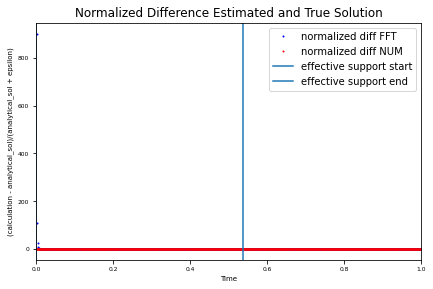

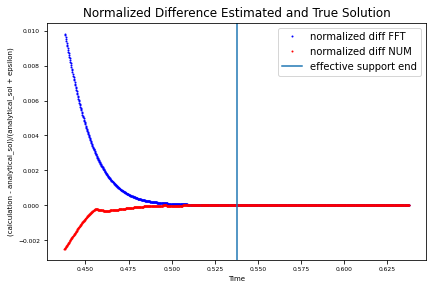

Absolute difference at end of effective support: 7.126461021096769e-17
Absolute difference at end plus epsilon of effective support: 7.126461016235946e-17
Absolute difference at start of effective support: 0.00025869831221902117
FFT grid points (output):134.0
NUM grid points (output):225.0


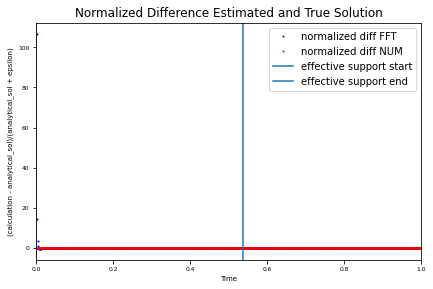

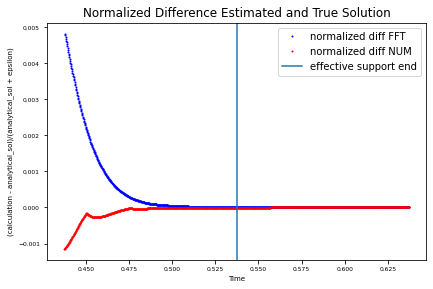

Absolute difference at end of effective support: 5.2742051151149783e-17
Absolute difference at end plus epsilon of effective support: 5.274205111797325e-17
Absolute difference at start of effective support: 2.2213821231862653e-05
FFT grid points (output):211.0
NUM grid points (output):328.0


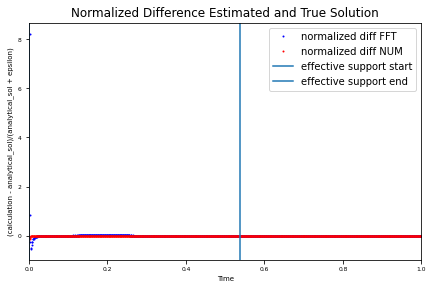

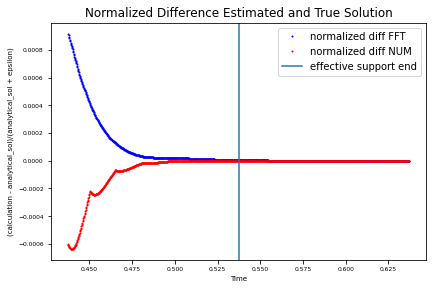

Absolute difference at end of effective support: 4.174733765005971e-17
Absolute difference at end plus epsilon of effective support: 4.1747337626487165e-17
Absolute difference at start of effective support: 9.785591617746595e-07
FFT grid points (output):406.0
NUM grid points (output):576.0


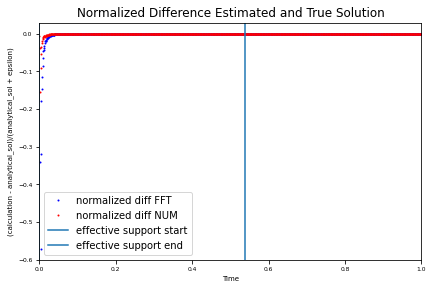

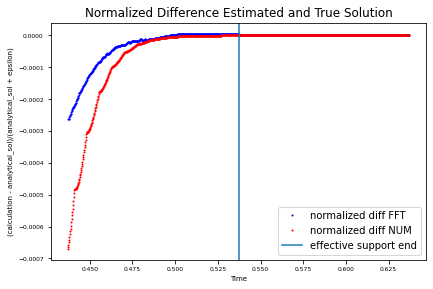

Absolute difference at end of effective support: 2.8186675414956394e-17
Absolute difference at end plus epsilon of effective support: 2.8186675401512035e-17
Absolute difference at start of effective support: 1.2761645331496396e-08
The bounds for the linear grid should be:-0.17200000000000004to 0.272
FFT grid points (output):57.0
NUM grid points (output):147.0


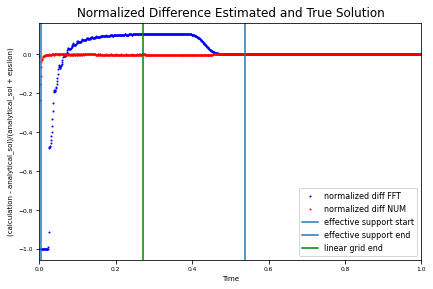

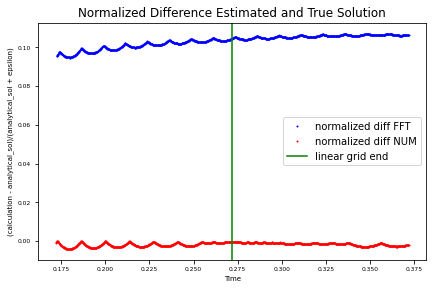

FFT grid points (output):95.0
NUM grid points (output):188.0


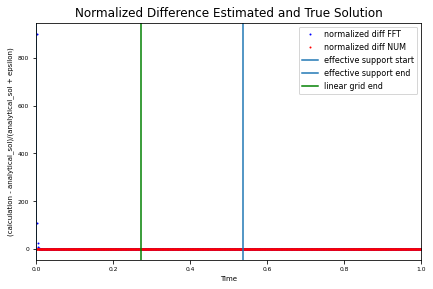

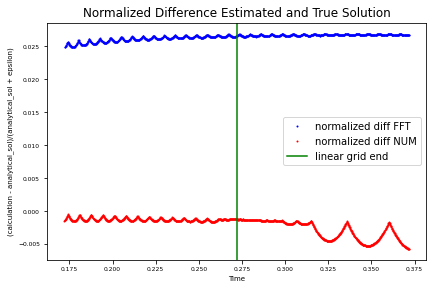

FFT grid points (output):134.0
NUM grid points (output):225.0


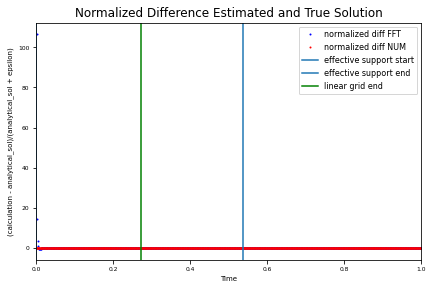

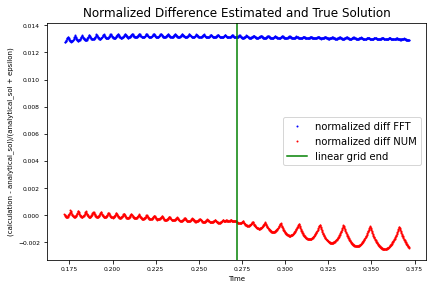

FFT grid points (output):211.0
NUM grid points (output):328.0


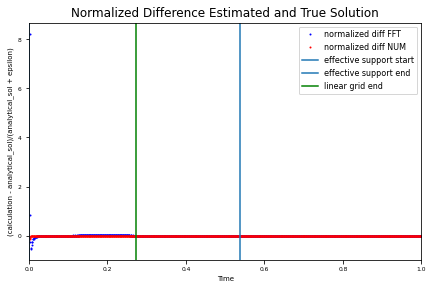

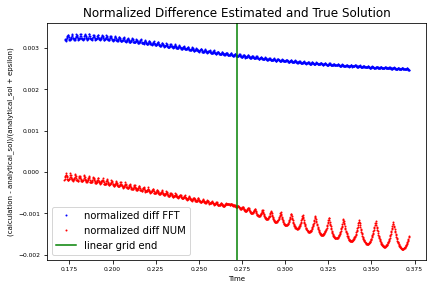

FFT grid points (output):406.0
NUM grid points (output):576.0


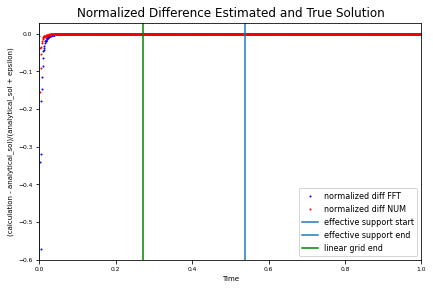

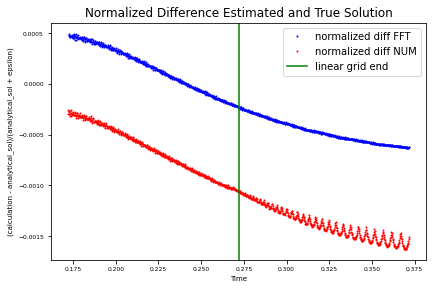

In [10]:
##in order to perform the convolution dist_2 needs a one_mutation parameter (as this should be a BranchLenInterpolator object)
dist_2_bl.one_mutation = 0

grid_size = [100, 200, 300, 500, 1000] #more desired grid_sizes, true grid size is given as output when the accuracy_and_time function is called
time_fft = np.empty((len(grid_size),2))
accuracy_fft = []
time_num = np.empty((len(grid_size),2))
accuracy_num = []
for t in range(len(grid_size)):
    #print(t)
    time_fft_full = accuracy_and_time(dist_1_bl, dist_2_bl, "fft", grid_size[t])
    time_fft[t] = time_fft_full[1:3]
    accuracy_fft.append(time_fft_full[0])
    time_num_full = accuracy_and_time(dist_1_bl, dist_2_bl, "num", grid_size[t])
    time_num[t] = time_num_full[1:3]
    accuracy_num.append(time_num_full[0])
    
print_relative_diff_grids()
print_relative_diff_grids_lin()